In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv("train.csv")
print("So mau : ",len(data))
data.head()

So mau :  1460


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


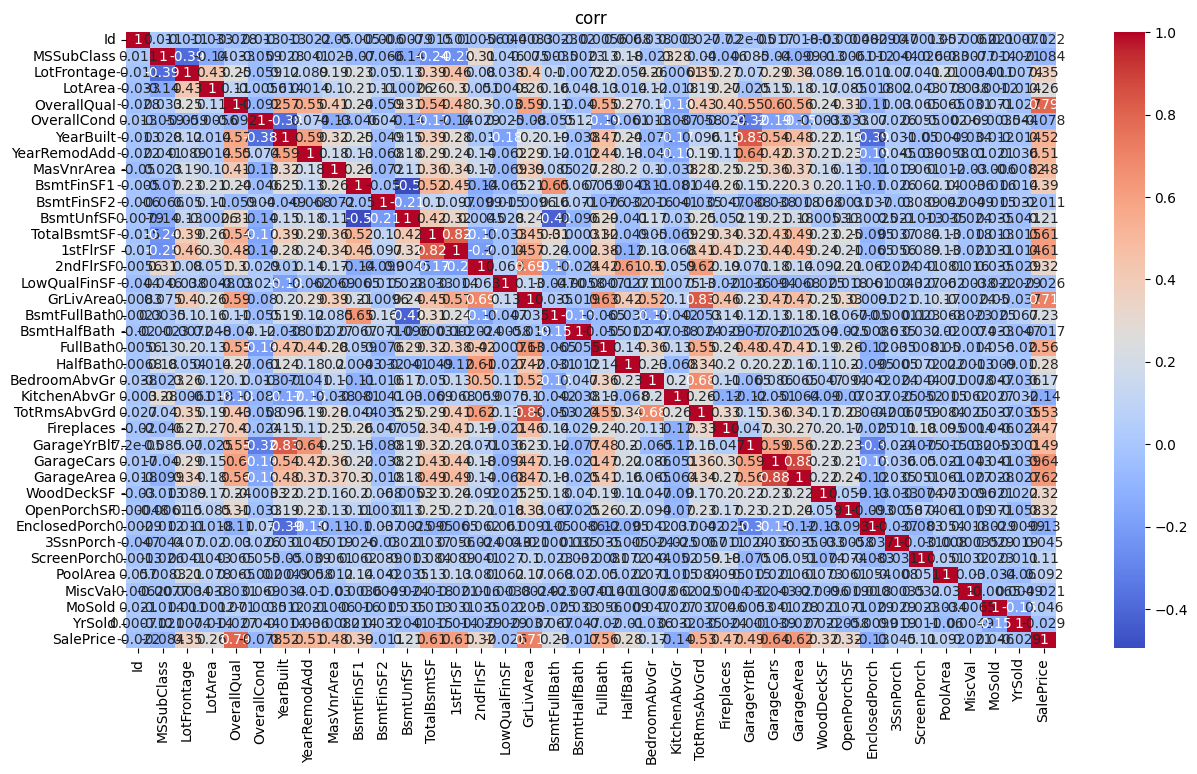

In [3]:
plt.figure(figsize=(15,8))
sns.heatmap(data.select_dtypes(include=['number']).corr(),cmap="coolwarm",annot=True)
plt.title("corr");


In [4]:
num_cols = data.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("SalePrice")
X=data[num_cols].fillna(0)
y=np.log1p(data["SalePrice"])

In [5]:
model=Ridge(alpha=0.1)
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

rmse_base=np.sqrt(-cross_val_score(model,X_scaled,y,cv=5,scoring="neg_mean_squared_error")).mean()

print(f"RMSE cơ bản: {rmse_base:.5f}")

RMSE cơ bản: 0.15401


In [13]:
# 3️⃣ Thêm Feature Engineering
X_fe = X.copy()
X_fe["Total_Home_Quality"] = X["OverallQual"] + X["OverallCond"]
X_fe["TotalSF"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
X_fe["Total_Bathrooms"] = X["FullBath"] + 0.5 * X["HalfBath"] + X["BsmtFullBath"] + 0.5 * X["BsmtHalfBath"]
X_fe["Age"] = X["YrSold"] - X["YearBuilt"]
X_fe["Remodeled"] = (X["YearRemodAdd"] != X["YearBuilt"]).astype(int)

# Các feature nâng cao bạn vừa gửi
X_fe["SqFtPerRoom"] = X["GrLivArea"] / (
    X["TotRmsAbvGrd"] + X["FullBath"] + X["HalfBath"] + X["KitchenAbvGr"]
)
X_fe["HighQualSF"] = X["1stFlrSF"] + X["2ndFlrSF"]

# Convert một số cột sang string (categorical)
for col in ["MSSubClass", "YrSold", "MoSold"]:
    X_fe[col] = X_fe[col].astype(str)

# Dummy hóa (one-hot encoding)
X_fe = pd.get_dummies(X_fe)


# Chuẩn hóa lại
X_fe_scaled = scaler.fit_transform(X_fe)
rmse_fe = np.sqrt(-cross_val_score(model, X_fe_scaled, y, cv=5, scoring="neg_mean_squared_error")).mean()
print(f"RMSE sau khi thêm feature: {rmse_fe:.5f}")
print(f"⚡ Cải thiện: {rmse_base - rmse_fe:.5f}")


RMSE sau khi thêm feature: 0.14782
⚡ Cải thiện: 0.00022


In [14]:
model2 = RandomForestRegressor(n_estimators=200, random_state=42)
rmse_base = np.sqrt(-cross_val_score(model2, X_fe_scaled, y, cv=5, scoring="neg_mean_squared_error")).mean()
rmse_fe = np.sqrt(-cross_val_score(model2, X_fe_scaled, y, cv=5, scoring="neg_mean_squared_error")).mean()

print(f"RMSE cơ bản: {rmse_base:.5f}")
print(f"RMSE sau khi thêm feature: {rmse_fe:.5f}")
print(f"⚡ Cải thiện: {rmse_base - rmse_fe:.5f}")

RMSE cơ bản: 0.14525
RMSE sau khi thêm feature: 0.14525
⚡ Cải thiện: 0.00000
